# Preprocessing dv/v for model fitting
2022.11.01 Kurama OKUBO

This notebook convert the output of dv/v in csv format from the `SeisMonitoring.smstats_read` to the .h5 dataset with preprocessing such as the channel weighting and the thresholding with correlation coefficient. The h5 dataset is used to estimate the model parameters using MCMC algorithm.

NOTE: For mwcs, we correct sign and magnitude of dvv ((-1) * 100) [\%] to synchronize with the result of stretching.
SeisDvv.MWCS() outputs the dt/T in fraction [-].

In [35]:
import datetime
import time

import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
%matplotlib inline

import numpy as np
import pandas as pd

import shutil
from tqdm import tqdm

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

In [36]:
rootdir = "../data"
csv_stats_names = ["monitoring_stats_uwbackup_2010-2022_stretching.csv", "monitoring_stats_uwbackup_2010-2022_mwcs.csv"]

csv_stats_list = [os.path.join(rootdir, x) for x in csv_stats_names]

In [37]:
#---set the file path of your case study list---#
csv_stats_id = 1

starttime = datetime.datetime(2002, 1, 1)
endtime = datetime.datetime(2022, 6, 1)

fitting_starttime = datetime.datetime(2002, 1, 1)#datetime.datetime(2008, 1, 1)
fitting_endtime = datetime.datetime(2022, 6, 1)#datetime.datetime(2018, 1, 1) # datetime.datetime(2013, 1, 1)

vlines = [datetime.datetime(2003, 12, 12), datetime.datetime(2004, 9, 28)] 

cc_time_unit=86400 # short-stacking time unit
averagestack_factor=30 # length of time bin to compute mean and std
averagestack_step=15

cc_threshold = 0.7 # threshold of correlation coefficient
err_mwcs_eps= 2e-4#0.5-0.9: 0.005  #[%]

dvv_eps=1.0 #[%] threshold for maximum dv/v value; this is arbitrarily chosen to remove too large dv/v values

freqid = 2 # id of frequency band: 1-4: see the block of freqbands: [0: '0.2-0.5', 1:'0.5-0.9', 2:'0.9-1.2', 3:'1.2-2.10']

output_imgdir = "../figure"
output_datadir = "../processed_data"
image_format="png"
dpi = 150
show=True
#-------------------------------------------#

if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)
    
if not os.path.exists(output_datadir):
    os.makedirs(output_datadir)

In [38]:
csv_stats = csv_stats_list[csv_stats_id]
dvvmethod = os.path.basename(csv_stats).split(".csv")[0].split("_")[-1]

In [39]:
# make uniform time vector
st_center = (averagestack_factor*cc_time_unit/86400)/2
date_range_st = starttime + datetime.timedelta(days=st_center) # day
date_range_st

datetime.datetime(2002, 1, 16, 0, 0)

In [40]:
datefreq = '%dD'%(averagestack_step*cc_time_unit/86400)
datefreq

'15D'

In [41]:
uniformdates = pd.date_range(start=date_range_st, end=endtime, freq=datefreq)

In [42]:
uniform_tvec = uniformdates.date

In [43]:
df_origin=pd.read_csv(csv_stats, dtype=str, comment='#')

#scan frequency band
freqbands = np.unique(df_origin.freqband) #freqid is corresponding to the index of this band
freqbands

array(['0.2-0.5', '0.5-0.9', '0.9-1.2', '1.2-2.0'], dtype=object)

In [44]:
# set dtype
df_origin['date'] = pd.to_datetime(df_origin['date'], format="%Y-%m-%dT%H:%M:%S.%f")

if dvvmethod=="stretching":
    df_origin['cc_dvv'] = df_origin['cc_ts'].astype(float)
    df_origin['dvv'] = df_origin['dvv_ts'].astype(float)
    df_origin['err'] = df_origin['err_ts'].astype(float)

elif dvvmethod=="mwcs":
    """
    We chose dvv_mwcs here, but you can also use dvv0_mwcs, which impose crossing at zero.
    """
    df_origin['dvv'] = (-1) * 100 * df_origin['dvv_mwcs'].astype(float) # convert the unit to [%]
    df_origin['err'] =  100 * df_origin['dvv_err_mwcs'].astype(float)

    
elif dvvmethod=="codaQ":
    df_origin['cc_dvv'] = df_origin['cc_dvv'].astype(float)
    df_origin['dvv'] = df_origin['dvv'].astype(float)

In [45]:
df_origin

,date,stationpair,networks,components,freqband,dvv_mwcs,dvv0_mwcs,dvv_err_mwcs,dvv0_err_mwcs,dvv,err
0,2002-05-16,BP.CCRB-BP.CCRB,BP-BP,11,0.2-0.5,-0.004202141111779931,-0.004202141593014656,1.6032154558632516e-5,1.6032122251148442e-5,0.420214,1.603215e-03
1,2002-05-16,BP.CCRB-BP.CCRB,BP-BP,11,0.5-0.9,0.00047500200217747617,0.0004782995489394368,3.0225200979495056e-7,3.0150154930237515e-7,-0.047500,3.022520e-05
2,2002-05-16,BP.CCRB-BP.CCRB,BP-BP,11,0.9-1.2,-0.0002544209653618679,-0.0004092988735225027,1.1636108854185343e-7,9.664286489118059e-8,0.025442,1.163611e-05
3,2002-05-16,BP.CCRB-BP.CCRB,BP-BP,11,1.2-2.0,0.0006919832045516637,0.0005558658183633814,5.89138998774463e-6,5.8684596503249385e-6,-0.069198,5.891390e-04
4,2002-05-31,BP.CCRB-BP.CCRB,BP-BP,11,0.2-0.5,-3.6065890721532164e-5,-3.2780282152109065e-5,3.1650222320287525e-6,3.1606102277351435e-6,0.003607,3.165022e-04
...,...,...,...,...,...,...,...,...,...,...,...
1185964,2022-05-01,BP.VCAB-BP.VCAB,BP-BP,33,1.2-2.0,1.4531688383075603e-5,2.000930308216782e-5,1.2065934948700813e-6,1.2318551809646882e-6,-0.001453,1.206593e-04
1185965,2022-05-16,BP.VCAB-BP.VCAB,BP-BP,33,0.2-0.5,-0.0012362734646587078,-0.0012362177778117215,5.610137386405975e-7,5.609985691458567e-7,0.123627,5.610137e-05
1185966,2022-05-16,BP.VCAB-BP.VCAB,BP-BP,33,0.5-0.9,-0.0003348099840670397,-0.0003357173260350196,2.0454088141648332e-7,2.0469418215310668e-7,0.033481,2.045409e-05
1185967,2022-05-16,BP.VCAB-BP.VCAB,BP-BP,33,0.9-1.2,-0.000554342554326686,-0.0005523833545014369,9.029720716963578e-9,9.492023608816122e-9,0.055434,9.029721e-07


## Gathering all dvv traces

1. filtering by frequency band
2. filtering by cc_threshold (stretching) or err_mwcs_eps (mwcs)
3. filtering by magnitude of dv/v value
4. compose traces

In [46]:
# scan station pairs
stationpairs_tmp = np.unique(df_origin.stationpair)
stationpairs = []
stationpairs = stationpairs_tmp
len(stationpairs)

83

In [47]:
# set frequency band
freqband = freqbands[freqid] #3, 5

# set components list
components_list = np.unique(df_origin.components)
# components_list = ['11', '22', '33', '12', '13', '23']

# Figure output directory
figdir = output_imgdir+"/alldvv_%s"%freqband
os.makedirs(figdir, exist_ok=True)

# filter by frequency band
df_freq = df_origin[df_origin.freqband==freqband]

# filter by cc_threshold 
if dvvmethod=="stretching":
    df_threshold = df_freq[df_freq.cc_dvv > cc_threshold]
    # filter by its magnitude
#     df_threshold=df_threshold[np.abs(df_threshold['dvv']) <  dvv_eps]

elif dvvmethod=="mwcs":
    df_threshold = df_freq[df_freq.err < err_mwcs_eps]
    # filter by its magnitude
#     df_threshold=df_threshold[np.abs(df_threshold['dvv']) <  0.01*dvv_eps]

elif dvvmethod=="codaQ":
    df_threshold = df_freq[df_freq.cc_dvv > cc_threshold]
    # filter by its magnitude
#     df_threshold=df_threshold[np.abs(df_threshold['dvv']) <  dvv_eps]

df_threshold

,date,stationpair,networks,components,freqband,dvv_mwcs,dvv0_mwcs,dvv_err_mwcs,dvv0_err_mwcs,dvv,err
2,2002-05-16,BP.CCRB-BP.CCRB,BP-BP,11,0.9-1.2,-0.0002544209653618679,-0.0004092988735225027,1.1636108854185343e-7,9.664286489118059e-8,0.025442,1.163611e-05
6,2002-05-31,BP.CCRB-BP.CCRB,BP-BP,11,0.9-1.2,0.0005553057648868045,0.0005556900137287386,4.0819791196266594e-8,3.168257377340152e-8,-0.055531,4.081979e-06
10,2002-06-15,BP.CCRB-BP.CCRB,BP-BP,11,0.9-1.2,0.0004077407253074981,0.0003565578479121071,2.459604519283731e-7,2.448343555285166e-7,-0.040774,2.459605e-05
14,2002-06-30,BP.CCRB-BP.CCRB,BP-BP,11,0.9-1.2,0.0008033238364549144,0.0007664050835908808,5.4710066262274567e-8,4.8037916379927665e-8,-0.080332,5.471007e-06
18,2002-07-15,BP.CCRB-BP.CCRB,BP-BP,11,0.9-1.2,-0.00025466726787296327,-0.0003289509168061084,1.2503387489523897e-7,1.09769939253162e-7,0.025467,1.250339e-05
...,...,...,...,...,...,...,...,...,...,...,...
1185951,2022-03-17,BP.VCAB-BP.VCAB,BP-BP,33,0.9-1.2,-0.0007905161721334302,-0.0008038270922682966,2.9581953562445462e-8,3.0605954503067057e-8,0.079052,2.958195e-06
1185955,2022-04-01,BP.VCAB-BP.VCAB,BP-BP,33,0.9-1.2,-0.00042989559476979805,-0.0004292420700437686,6.834142768973619e-8,6.85494271828339e-8,0.042990,6.834143e-06
1185959,2022-04-16,BP.VCAB-BP.VCAB,BP-BP,33,0.9-1.2,-0.0008050337984601422,-0.001340689525286779,5.06832491479942e-8,6.707411882871631e-8,0.080503,5.068325e-06
1185963,2022-05-01,BP.VCAB-BP.VCAB,BP-BP,33,0.9-1.2,-0.0003569850068606812,-0.00035408386447641297,3.572288633087495e-8,3.5463619506924873e-8,0.035699,3.572289e-06


<AxesSubplot:xlabel='date', ylabel='[err]'>

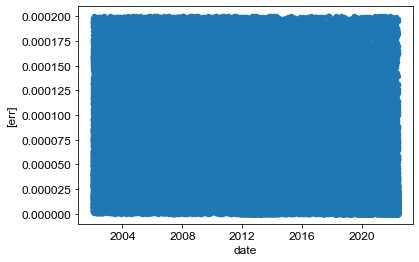

In [48]:
df_threshold.plot.scatter(x="date", y=["err"])

# Evaluate asymmetric in dv/v of auto correlation cross-channel

As the auto-correlation function of single station is symmetric to the lag time, dv/v with cross-channel (e.g. 12 and 21) should be identical. However, the data in our csv shows small difference between them. This is caused by the asymmetric in interpolation with cubic spline fitting in the case of stretching method. Although the $\epsilon$ in Stretching.jl is symmetric in the origin, The data point used for fitting is not symmetric (see https://github.com/tclements/SeisDvv.jl/blob/master/src/Stretching.jl). This causes a difference within a grid size of searching dv/v. We also think the cause in the case of mwcs method might be associated with the GLM. 

Here we show that the difference in dv/v, showing the most pairs are very close, and thus it does not have any effect on our result on dv/v time series.

In [49]:
# scan station pairs
stationpairs_tmp = np.unique(df_origin.stationpair)
stationpairs_auto = []
for st in stationpairs_tmp:
    sta1, sta2 = st.split("-")
    if sta1 == sta2:
        stationpairs_auto.append(st)

len(stationpairs_auto)

13

In [50]:
components_asymmetric = ["12", "13", "23"] # components to be evaluated on the residual to the flipped component

In [51]:
res_auto_dvv = []

# stationpair = stationpairs_auto[7]
# comp = components_asymmetric[0]
for stationid in tqdm(range(len(stationpairs_auto))):
    stationpair = stationpairs_auto[stationid]
    for comp in components_asymmetric:
        df_pair = df_threshold[df_threshold.stationpair==stationpair]
        df_pair_1 = df_pair[df_pair.components==comp]
        df_pair_2 = df_pair[df_pair.components==comp[::-1]]
        for dateid in range(len(df_pair_1.date)):
            # dateid = 10
            df_pair_1_date = df_pair_1.iloc[dateid]
            df_pair_2_date = df_pair_2[df_pair_2.date == df_pair_1.date.iloc[dateid]]

            if df_pair_2_date.empty:
                print(df_pair_1_date.err) # this skipping occurs due to the cc_thresholding
                continue;
                
            if dvvmethod=="stretching":

                cc_dvv_1 = df_pair_1_date.cc_dvv
                dvv_1 = df_pair_1_date.dvv #[%]
                cc_dvv_2 = df_pair_2_date.cc_dvv.values[0]
                dvv_2 = df_pair_2_date.dvv.values[0] #[%]

                if (cc_dvv_1 > cc_threshold) &  (cc_dvv_2 > cc_threshold):
                    res_auto_dvv.append(np.abs(dvv_2-dvv_1)) # append residual to the list
                    
            elif dvvmethod=="mwcs":
                err_dvv_1 = df_pair_1_date.err
                dvv_1 = df_pair_1_date.dvv #[%]
                err_dvv_2 = df_pair_2_date.err.values[0]
                dvv_2 = df_pair_2_date.dvv.values[0] #[%]
                if (err_dvv_1 < err_mwcs_eps) & (err_dvv_2 < err_mwcs_eps):
                    res_auto_dvv.append(np.abs(dvv_2-dvv_1)) # append residual to the list


  0%|                                                    | 0/13 [00:00<?, ?it/s]

0.00013759985539439932
0.00017094714078347804
0.00017955312351503755


  8%|███▍                                        | 1/13 [00:00<00:05,  2.05it/s]

0.00017410371302446718
9.56872893502092e-05
0.00014718715454192124


 23%|██████████▏                                 | 3/13 [00:01<00:04,  2.42it/s]

0.0001907037669652189
0.00018645782613481624
0.00018021651204494754
0.00010685186600987362
7.474344403437837e-05
0.0001984301595859227
0.00018055106144773081
0.00017516157921655716
0.00013774525863122794
0.0001437453388074426
0.00011021290498262381
0.00019933452699443674
0.00017490877712894926
0.00018281973805691102
0.00014695651296439457
0.00010506834351787783
0.00016114887073109384
0.00014564595718652006
0.00018198156012209967
0.00017071485210485646
0.00014361042712002619
0.00015381108874272623
7.077467357753612e-05
0.00014193401158417516
0.00016098248952744657
0.0001654066626970745
0.0001611164973440687
0.00011537878986729338
0.0001716033155864818
0.0001767678583669424
8.288880410968775e-05
0.00018270579694673305

 31%|█████████████▌                              | 4/13 [00:01<00:03,  2.86it/s]


0.000187267545914707
9.516279082513341e-05
0.00017980164996927433
0.0001690680756550387
0.00011966166762779001
4.7941475800375974e-05
0.0001400244856311381
0.0001928864931202982
0.00018917860443564606
0.00019427541224182154
0.00010688065455705357
0.0001493588096520586
0.00014719417779114827
0.00010861075099580093
0.00010881024400109003
0.00010075368559270545
0.00017676988820299663
0.00010004635952174436
0.0001603981794705151
0.0001395883396108587
0.00011981864760613058
0.00019979457945891948
0.00011979012396264395
3.788606665752334e-05
8.69201514434262e-05
0.0001322320064743803
0.00015273402238564885
0.00016789492873826422
0.00019421398702711216

 38%|████████████████▉                           | 5/13 [00:01<00:02,  3.18it/s]


0.00013744533724227348
0.00015950482814952984
0.00018717051857430775
0.00016968242761182986
0.00019702321054587083
0.00016849111022063362
0.00018383648827049144
0.00014663522973071
3.007788502346118e-05
0.0001147294472899849
0.00010369828272141187
0.0001872840398282685
0.00019696476835512333
0.00013848837077909084
0.00017717932521182009
5.296014215314406e-05
0.00014325133593637112
0.00010568360207115915
0.00015439728178515523
0.00013483021443371206
0.00019158062638420113
4.651406166213401e-05
0.0001978697939515066
0.00018851566329208352
0.00013911286980843794
5.438561633987718e-05
0.00014492744450739093
8.565811735346775e-05
0.00017944641887773734
0.00018484730020058333
0.0001755204518042681

 46%|████████████████████▎                       | 6/13 [00:01<00:01,  3.56it/s]


0.00018417950403563322
0.00019289876452387414
0.0001611106924548181
0.00018814108045607186
0.00012757122338215692
0.0001813527802528162
0.00014272531144056348
0.0001793936157110244
0.0001775508692023823
0.0001944702652391345
0.00015192547658232565
0.00019467491147414284
0.00013053904421102752
5.865055482591285e-05
0.00012766126476419911
0.00013930166353375093
0.00017090822550060153
0.00011373570522002355
0.00012229228279950658
0.00014974322887757987
0.00018022153848934098
0.00014295481676160338
0.00017379670164306395
0.00014223888636001486
0.00014989578960503437
0.00015592537214429114
0.0001844203430386491
0.00014802381843250032
0.00013329987352112793
0.0001872223018039805


 54%|███████████████████████▋                    | 7/13 [00:02<00:02,  2.88it/s]

0.00019433938943460324
0.00017767082565225164
0.00011371179277971972
0.0001575916388938372
2.9545802549888727e-05
0.00018669351470053895
0.00015751695055710714


 62%|███████████████████████████                 | 8/13 [00:02<00:01,  2.61it/s]

0.00019679768904989594
0.00019826046964998683
0.00018276402819088132


 69%|██████████████████████████████▍             | 9/13 [00:03<00:01,  2.88it/s]

0.00019780101422219265
0.00019116320977535965


 77%|█████████████████████████████████          | 10/13 [00:03<00:01,  2.52it/s]

0.0001235087429008245
0.0001235087429008245
0.00019207228121789841
0.00015466725509247125
0.00016432933116686892
0.00017113198958281748
0.0001599112176892448
0.0001808153111774174
0.00013539453031319508
0.0001642359752412625
0.0001968917737503229
0.0001995519597863102
0.0001778511677596991
0.00018672762333709814
0.00017933713462220285
0.00012548596141683912
0.0001920519593375948
0.00017859811289323626
0.00013366248477427053
0.0001499429475140116
0.00016750292076878358
0.00011791318346288213
0.0001925288643151134


 92%|███████████████████████████████████████▋   | 12/13 [00:04<00:00,  2.81it/s]

0.00015522049901517317
0.000190699898291068
0.00017069957370724568
0.00017228695224080485
0.0001657034147149267
0.0001886146276234192
0.0001913698489508046
0.00019659595822116654
0.00015612129658554308
0.00014959208386019487
0.00019338853710561022
0.00015186515186617407
0.00017903716174871628
0.00013868913546134394
0.00019062263952740845
0.00017136974597808683
0.00016916308840987367
0.00018483567023354938
0.00016900954583786573
0.0001693666458630994
0.00019796156370619375
0.00015176284102360913
0.00018154107355188576
0.00015008994641598273
0.00013156938928834264
0.0001256523289101349


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.69it/s]


In [52]:
df_pair

,date,stationpair,networks,components,freqband,dvv_mwcs,dvv0_mwcs,dvv_err_mwcs,dvv0_err_mwcs,dvv,err
1168577,2002-01-16,BP.VCAB-BP.VCAB,BP-BP,11,0.9-1.2,5.091949527560205e-5,-3.446445417123801e-6,1.505848608641339e-8,1.4650418715741343e-8,-0.005092,1.505849e-06
1168581,2002-01-31,BP.VCAB-BP.VCAB,BP-BP,11,0.9-1.2,0.00029166089568177084,0.0003212434439701849,7.097663067900898e-8,7.259824904017774e-8,-0.029166,7.097663e-06
1168585,2002-02-15,BP.VCAB-BP.VCAB,BP-BP,11,0.9-1.2,0.00014835633277569363,0.0001246980285701278,7.84211013211007e-8,7.848133439842466e-8,-0.014836,7.842110e-06
1168589,2002-03-02,BP.VCAB-BP.VCAB,BP-BP,11,0.9-1.2,0.00023641734696955042,0.00023895731811987607,1.4675835718823846e-7,1.4663559058467435e-7,-0.023642,1.467584e-05
1168593,2002-03-17,BP.VCAB-BP.VCAB,BP-BP,11,0.9-1.2,0.0004666761543603823,0.0004646164461602946,7.051434202590717e-8,6.99279769346807e-8,-0.046668,7.051434e-06
...,...,...,...,...,...,...,...,...,...,...,...
1185951,2022-03-17,BP.VCAB-BP.VCAB,BP-BP,33,0.9-1.2,-0.0007905161721334302,-0.0008038270922682966,2.9581953562445462e-8,3.0605954503067057e-8,0.079052,2.958195e-06
1185955,2022-04-01,BP.VCAB-BP.VCAB,BP-BP,33,0.9-1.2,-0.00042989559476979805,-0.0004292420700437686,6.834142768973619e-8,6.85494271828339e-8,0.042990,6.834143e-06
1185959,2022-04-16,BP.VCAB-BP.VCAB,BP-BP,33,0.9-1.2,-0.0008050337984601422,-0.001340689525286779,5.06832491479942e-8,6.707411882871631e-8,0.080503,5.068325e-06
1185963,2022-05-01,BP.VCAB-BP.VCAB,BP-BP,33,0.9-1.2,-0.0003569850068606812,-0.00035408386447641297,3.572288633087495e-8,3.5463619506924873e-8,0.035699,3.572289e-06


In [53]:
# Figure output directory
figdir = output_imgdir+"/asymmetric_autocorr_%s"%freqband
os.makedirs(figdir, exist_ok=True)

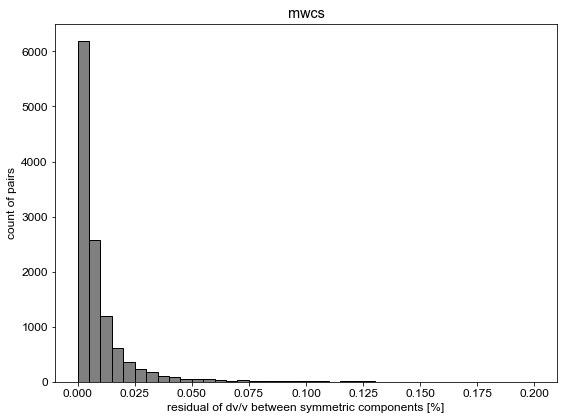

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

if dvvmethod=="stretching":
    ax.hist(res_auto_dvv, bins=40, range=(0, 0.05), edgecolor="k", facecolor="grey")
    ax.set_xlabel('residual of dv/v between symmetric components [%]')
    ax.set_ylabel('count of pairs')
    ax.axvline(0.02, color="k", ls="--")
    ax.text(0.021, 3000, "size of minimum grid search", fontsize=16)
    ax.set_title('stretching')
    plt.tight_layout()
    foname = (figdir+"/asymmetric_autocorr_residualhist_stretching.png")
    plt.savefig(foname)
    
if dvvmethod=="mwcs":
    # ax.hist(res_auto_dvv, bins=20, range=(0, 0.05), edgecolor="k", facecolor="grey")
    ax.hist(res_auto_dvv, bins=40, range=(0, 0.2), edgecolor="k", facecolor="grey")
    ax.set_xlabel('residual of dv/v between symmetric components [%]')
    ax.set_ylabel('count of pairs')
    ax.set_title('mwcs')
#     ax.axvline(0.02, color="k", ls="--")
#     ax.text(0.021, 3000, "size of minimum grid search", fontsize=16)
    plt.tight_layout()
    foname = (figdir+"/asymmetric_autocorr_residualhist_mwcs.png")
    plt.savefig(foname)

In [55]:
np.percentile(res_auto_dvv, 90)

0.022169653676493525

## Compute dvv with channel weight
From Hobiger et al., 2014

$$ \dfrac{dv}{v}(t) = \dfrac{\sum_{k=1}^N c_k^2 (t) \dfrac{dv}{v}_k (t)}{\sum_{k=1}^N c_k^2 (t) } $$

$$ c(t) = \dfrac{\sum_{k=1}^N c_k^3 (t)}{\sum_{k=1}^N c_k^2 (t) } $$

The error can be evaluated with error propagation such that

$$ \overline{dvv}(dvv_1, dvv_2, ..., dvv_9) = \dfrac{\sum_{k=1}^{N}c_{k}^2 dvv_{k}}{\sum_{k=1}^{N}c_{k}^2} $$

$$ \sigma_{wav} = \sqrt{\sum_{i=1}^9 \left(\dfrac{\partial \overline{dvv}}{\partial dvv_i} \right)^2 \sigma_{n, i}^2} $$

$$ \sigma_{wav} = \sqrt{\sum_{i=1}^9 \left(\dfrac{c_i^2}{\sum_k c_k^2} \right)^2 \sigma_{n, i}^2} $$

For MWCS, We simplefy the weighting method as it already apply weights on the coda part, described as following:

$$ \dfrac{dv}{v}(t) = \dfrac{\sum_{k=1}^N \dfrac{dv}{v}_k (t)}{N } $$

$$ c(t) = 1.0 $$

In [56]:
# compute channel weight and store into dataframe
columns=["date", "stationpair", "freqband", "cc_weight", "dvv", "err" ]
df_threshold_weight = pd.DataFrame(columns = columns)

for stationid in tqdm(range(len(stationpairs))):
    stationpair = stationpairs[stationid]
    df_pair = df_threshold[df_threshold.stationpair==stationpair]
    df_pair = df_pair[df_pair.components .isin(components_list)]
    datelist = np.unique(df_pair.date) # this indicates that datelist includes even the case that one channel pair is available, leading to enhance the data continuity.
    for d in datelist:
        df_comp = df_pair[df_pair.date == d] #include all components available at this datetime
        N = len(df_comp)
        cdvv_all = 0 
        c2_all = 0
        c3_all = 0
        err_sum2 = 0
        
        if N == 0:
            print(d)
            continue;
        
        for index, row in df_comp.iterrows():
            if dvvmethod=="stretching":
                cdvv_all = cdvv_all + row.cc_dvv**2 * row.dvv
                c2_all = c2_all + row.cc_dvv**2
                c3_all = c3_all + row.cc_dvv**3
#                 err_sum2 = row.err**2
                err_sum2 = err_sum2 + (row.cc_dvv**4)*row.err**2 # corrected the power from 2 to 4: 2022/09/26  Kurama Okubo
                
            elif dvvmethod=="mwcs":
                cdvv_all = cdvv_all + 1.0 * row.dvv
                c2_all = c2_all + 1.0
                c3_all = c3_all + 1.0
                err_sum2 = err_sum2 + (1.0**4)*row.err**2 # in this case, the error is RMS of all components.
                
        dvv_weight = cdvv_all/c2_all
        cc_weight = c3_all/c2_all
#         err_weight = np.sqrt(err_sum2)
        err_weight = np.sqrt(err_sum2)/c2_all
        
        df_weight_tmp = pd.DataFrame({"date":[d], "stationpair":[stationpair], "freqband":[freqband],
                                      "cc_weight":[cc_weight], "dvv":[dvv_weight], "err":[err_weight]})
        
        df_threshold_weight = df_threshold_weight.append(df_weight_tmp)
        
        

100%|███████████████████████████████████████████| 83/83 [00:49<00:00,  1.67it/s]


In [57]:
df_threshold_weight

,date,stationpair,freqband,cc_weight,dvv,err
0,2002-05-16,BP.CCRB-BP.CCRB,0.9-1.2,1.0,0.013302,0.000013
0,2002-05-31,BP.CCRB-BP.CCRB,0.9-1.2,1.0,-0.037674,0.000004
0,2002-06-15,BP.CCRB-BP.CCRB,0.9-1.2,1.0,-0.034586,0.000014
0,2002-06-30,BP.CCRB-BP.CCRB,0.9-1.2,1.0,-0.017976,0.000011
0,2002-07-15,BP.CCRB-BP.CCRB,0.9-1.2,1.0,0.017218,0.000008
...,...,...,...,...,...,...
0,2022-03-17,BP.VCAB-BP.VCAB,0.9-1.2,1.0,0.031112,0.000001
0,2022-04-01,BP.VCAB-BP.VCAB,0.9-1.2,1.0,0.036432,0.000001
0,2022-04-16,BP.VCAB-BP.VCAB,0.9-1.2,1.0,0.054801,0.000002
0,2022-05-01,BP.VCAB-BP.VCAB,0.9-1.2,1.0,0.037922,0.000002


<AxesSubplot:xlabel='date', ylabel='[err]'>

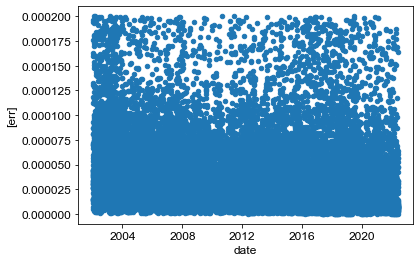

In [58]:
df_threshold_weight.plot.scatter(x="date", y=["err"])

In [59]:
len(np.unique(df_threshold_weight.stationpair))

83

## Threshold out the dvv traces

Each dv/v trace is evaluated in terms of

1. continuity (data contents) over all / fitting period

~~2. stability (std)~~

We store the all dv/v with data contents, which will be used in the following processes.

In [60]:
# compute length of fitting period
fitting_tlen = sum([(fitting_starttime < datetime.datetime.fromordinal(x.toordinal())) &
                    (datetime.datetime.fromordinal(x.toordinal()) < fitting_endtime) for x in uniform_tvec])
fitting_tlen

497

In [61]:
0.07402805611222446 - 0.07234468937875752

0.0016833667334669455

In [62]:
import h5py

In [63]:
stationpair = stationpairs[10]

In [64]:
df_threshold_weight_pair = df_threshold_weight[df_threshold_weight.stationpair == stationpair]

In [65]:
np.asarray(df_threshold_weight_pair.cc_weight)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [66]:
with h5py.File(output_datadir+"/dvvtraces_chanweighted_{}_{}.h5".format(csv_stats_names[csv_stats_id], freqband), "w") as h5: # overwrite data
    
    h5.attrs["cc_threshold"] = cc_threshold
    h5.attrs["cc_time_unit"] = 86400 # short-stacking time unit
    h5.attrs["averagestack_factor"] = 30
    h5.attrs["averagestack_step"] = 15    
    h5.create_dataset('uniform_tvec', data=uniform_tvec.astype('datetime64[s]').astype(int))

    for pairname in tqdm(stationpairs):
        # read parameters from dictionary
        df_threshold_weight_pair = df_threshold_weight[df_threshold_weight.stationpair == pairname]
        t = np.asarray(df_threshold_weight_pair.date)
        dvv = np.asarray(df_threshold_weight_pair.dvv)
        
        if dvvmethod=="stretching":
            cc = np.array(df_threshold_weight_pair.cc_weight)
            err = np.array(df_threshold_weight_pair.err)
            
        elif dvvmethod=="mwcs":
            cc = np.array(df_threshold_weight_pair.cc_weight)
            err = np.array(df_threshold_weight_pair.err)            
#             err = df_singletrace["err"]

        # compute datacontents over all period
        datacontents = len(dvv)/len(uniform_tvec)
        
        # compute datacontents over fitting period
        fitdatalen = sum([(fitting_starttime < pd.to_datetime(x)) & 
                  (pd.to_datetime(x) < fitting_endtime) for x in t])
        
        fitdatacontents = fitdatalen / fitting_tlen
        print(fitdatacontents)
        
        std_dvv = np.std(dvv)

        # store into h5
        gname = "dvv/"+pairname
        h5.require_group(gname)
        h5[gname].create_dataset('t_unix', data=t.astype('datetime64[s]').astype(int))
        h5[gname].create_dataset('dvv', data=dvv)
        if dvvmethod=="stretching":
            h5[gname].create_dataset('cc', data=cc)
            h5[gname].create_dataset('err', data=err)
        elif dvvmethod=="mwcs":
            h5[gname].create_dataset('cc', data=cc)
            h5[gname].create_dataset('err', data=err)
            
        h5[gname].create_dataset('datacontents', data=datacontents)
        h5[gname].create_dataset('fitcontents', data=fitdatacontents)
        h5[gname].create_dataset('std_dvv', data=std_dvv)

  6%|██▋                                         | 5/83 [00:00<00:01, 42.74it/s]

0.9114688128772636
0.8893360160965795
0.6921529175050302
0.5130784708249497
0.8108651911468813
0.8812877263581489
0.8490945674044266
0.40643863179074446
0.8832997987927566


 18%|███████▊                                   | 15/83 [00:00<00:01, 42.40it/s]

0.8591549295774648
0.6197183098591549
0.8792756539235412
0.9979879275653923
0.8470824949698189
0.8772635814889336
0.7645875251509054
0.9818913480885312


 28%|███████████▉                               | 23/83 [00:00<00:01, 39.23it/s]

0.9839034205231388
0.9275653923541247
0.46680080482897385
0.959758551307847
0.93158953722334
0.7303822937625755
0.9617706237424547
0.6800804828973843
0.7505030181086519


 40%|█████████████████                          | 33/83 [00:00<00:01, 42.00it/s]

0.5915492957746479
0.8611670020120724
0.8611670020120724
0.7605633802816901
0.45271629778672035
0.7706237424547284
0.8289738430583501
0.710261569416499
0.8269617706237424


 52%|██████████████████████▎                    | 43/83 [00:01<00:00, 43.89it/s]

0.8993963782696177
0.5653923541247485
0.8712273641851107
0.7022132796780685
0.6780684104627767
0.7283702213279678
0.6317907444668008
0.6941649899396378
0.6237424547283702
0.5110663983903421


 64%|███████████████████████████▍               | 53/83 [00:01<00:00, 44.41it/s]

0.5613682092555332
0.6297786720321932
0.9537223340040242
0.9476861167002012
0.89738430583501
0.4245472837022133
0.8712273641851107
0.8853118712273642
0.7344064386317908


 70%|██████████████████████████████             | 58/83 [00:01<00:00, 40.55it/s]

0.9235412474849095
0.9899396378269618
0.9295774647887324
0.4607645875251509
0.959758551307847
0.93158953722334
0.7283702213279678


 82%|███████████████████████████████████▏       | 68/83 [00:01<00:00, 41.29it/s]

0.9577464788732394
0.9255533199195171
0.42655935613682094
0.9134808853118712
0.8893360160965795
0.6237424547283702
0.903420523138833
0.4688128772635815
0.4346076458752515
0.44668008048289737
0.3963782696177062


 95%|████████████████████████████████████████▉  | 79/83 [00:01<00:00, 44.32it/s]

0.46680080482897385
0.9637826961770624
0.9235412474849095
0.6378269617706237
0.9356136820925554
0.9416498993963782
0.7002012072434608
0.93158953722334
0.744466800804829


100%|███████████████████████████████████████████| 83/83 [00:01<00:00, 42.80it/s]

0.6639839034205232
0.9496981891348089


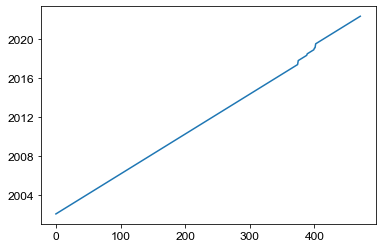

In [67]:
plt.plot(df_threshold_weight_pair.date.values)

In [68]:
df_threshold_weight_pair

,date,stationpair,freqband,cc_weight,dvv,err
0,2002-01-16,BP.VCAB-BP.VCAB,0.9-1.2,1.0,-0.006828,0.000005
0,2002-01-31,BP.VCAB-BP.VCAB,0.9-1.2,1.0,-0.012517,0.000003
0,2002-02-15,BP.VCAB-BP.VCAB,0.9-1.2,1.0,-0.029207,0.000006
0,2002-03-02,BP.VCAB-BP.VCAB,0.9-1.2,1.0,-0.047641,0.000003
0,2002-03-17,BP.VCAB-BP.VCAB,0.9-1.2,1.0,-0.050960,0.000004
...,...,...,...,...,...,...
0,2022-03-17,BP.VCAB-BP.VCAB,0.9-1.2,1.0,0.031112,0.000001
0,2022-04-01,BP.VCAB-BP.VCAB,0.9-1.2,1.0,0.036432,0.000001
0,2022-04-16,BP.VCAB-BP.VCAB,0.9-1.2,1.0,0.054801,0.000002
0,2022-05-01,BP.VCAB-BP.VCAB,0.9-1.2,1.0,0.037922,0.000002
